In [146]:
import random
 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [147]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.utils import plot_images, sliding_average

import pickle

In [148]:
def process_datasets():

    ftrain = open('./SwedishLeaf/SwedishLeaf_TRAIN.tsv')
    ftest = open('./SwedishLeaf/SwedishLeaf_TEST.tsv')
    
    values = []
    cols = ["ts", "class"]
    indices = list(range(0,500))

    for i in ftrain:
        res = i.split()
        resInt = [eval(x) for x in res[1:]]
        values.append([resInt, int(res[0])-1])
        
    dfTrain = pd.DataFrame(values, indices, cols)
    
    values = []
    indices = list(range(0,625))
    
    for i in ftest:
        res = i.split()
        resInt = [eval(x) for x in res[1:]]
        values.append([resInt, int(res[0])-1])
    
    dfTest = pd.DataFrame(values, indices, cols)
    
    return dfTrain, dfTest

In [149]:
dfTrain, dfTest = process_datasets()

In [150]:
def normalize_column(col):
    ls = []
    for xs in col:
        l = []
        for x in xs:
            l.append((x - min(xs))/ (max(xs)- min(xs)))
        ls.append(l)
    return ls

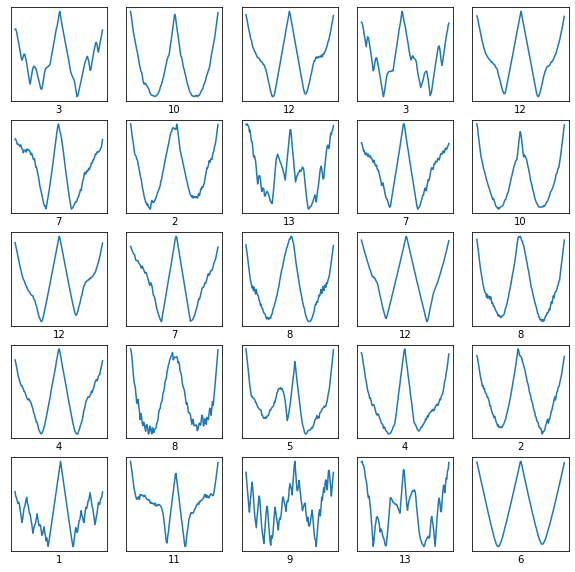

In [151]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot(list(range(0,128)),dfTrain.iloc[i][0])
    plt.xlabel(dfTrain.iloc[i][1])
plt.show()

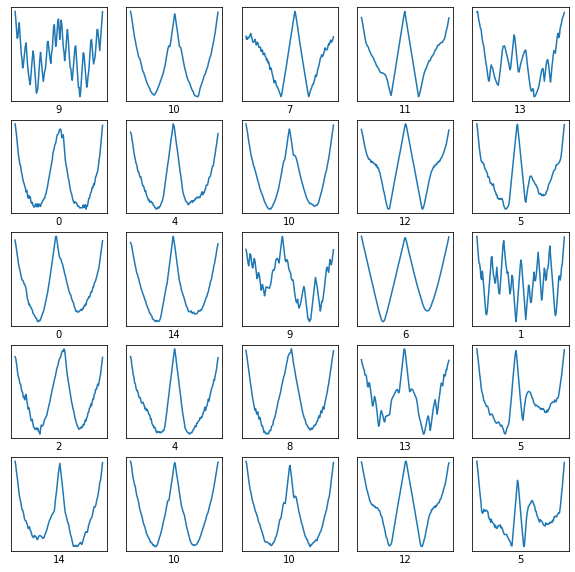

In [152]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot(list(range(0,128)),dfTest.iloc[i][0])
    plt.xlabel(dfTest.iloc[i][1])
plt.show()

In [153]:
set(dfTrain['class'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [154]:
set(dfTest['class'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

### Measures

In [155]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

### Treating data

In [156]:
ls = normalize_column(dfTrain['ts'])
dfTrain['ts'] = ls
ls = normalize_column(dfTest['ts'])
dfTest['ts'] = ls

In [157]:
len(dfTrain['ts'][0])

128

### Prototypical networks class
Instantiated with a backbone: pretrained model and we obtain the embedding with the Dense layer.

In [190]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
convolutional_network.conv1 = nn.Conv2d(128,64,(7,7), stride=(2,2), padding=(3,3), bias=False)
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cpu()

ResNet(
  (conv1): Conv2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


### Dataset class


In [191]:
from torch.utils.data import Dataset

class SwedishLeaves(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.get_ts = torch.as_tensor(df['ts']).unsqueeze(-1).unsqueeze(-1)
        self.get_labels = lambda: [
            instance for instance in df['class']
        ]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.get_labels)

    def __getitem__(self, idx):
        return (self.get_ts[idx], self.get_labels()[idx])

In [192]:
train_set = SwedishLeaves(dfTrain)
test_set = SwedishLeaves(dfTest)

In [194]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance for instance in dfTest['class']
]

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [208]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

#plot_images(example_support_images, "support images", images_per_row=N_SHOT)
#plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [219]:
model.eval()
example_scores = model(
    example_support_images.cpu(),
    example_support_labels.cpu(),
    example_query_images.cpu(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        str(test_set.get_labels()[example_class_ids[example_query_labels[i]]]) + "            /        " + str(test_set.get_labels()[example_class_ids[example_predicted_labels[i]]])
        #f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
9            /        9
9            /        9
9            /        7
9            /        7
9            /        1
9            /        9
9            /        7
9            /        1
9            /        9
9            /        9
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
1            /        1
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
7            /        7
0            /        0
0            /        0
0            /        1
0            /        1
0            /        0
0            /        0
0            /        0
0            /        1
0            /        0
0            /        10
10            

In [220]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cpu(), support_labels.cpu(), query_images.cpu())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cpu()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.82it/s]

Model tested on 100 tasks. Accuracy: 74.04%


### Training a meta-training algorithm

In [225]:
N_TRAINING_EPISODES = 2000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance for instance in dfTrain['class']]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [226]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cpu(), support_labels.cpu(), query_images.cpu()
    )

    loss = criterion(classification_scores, query_labels.cpu())
    loss.backward()
    optimizer.step()

    return loss.item()

In [227]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|████████████████████████████████████████████████████████████████████| 2000/2000 [18:45<00:00,  1.78it/s, loss=0.2]


In [228]:
evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.90it/s]

Model tested on 100 tasks. Accuracy: 90.72%
